In [3]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [34]:
path = './reviews.csv'
df = pd.read_csv(path)

In [35]:
df.shape

(786, 5)

In [36]:
df.head()

,Title,Content,Rating,Date,Action
0,Creative but preachy and confusing,I'm just going to get straight to the point: I...,6/10,23 July 2023,"782 out of 1,050 found this helpful. Was this ..."
1,"Beautiful film, but so preachy","Margot does the best with what she's given, bu...",6/10,21 July 2023,"1,038 out of 1,440 found this helpful. Was thi..."
2,Clever and fun beginning turns into another le...,"Barbie begins in an irresistible way, as a fun...",6/10,21 July 2023,"712 out of 1,019 found this helpful. Was this ..."
3,It was depressing,NaN,8/10,24 July 2023,80 out of 123 found this helpful. Was this rev...
4,Barbie Is A Weirdly Fun Movie!,"8.5/10 While i'm not so sure at first, the mov...",8/10,19 July 2023,"497 out of 1,158 found this helpful. Was this ..."


### Preprocessing

In [37]:
df['Rating'] = df['Rating'].apply(lambda x: x.split('/10')[0])
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Rating'] = df['Rating'].fillna(-1).astype(int)

In [38]:
df['Date'] = pd.to_datetime(df['Date'], format='%d %B %Y')

In [39]:
df['Title'] = df['Title'].fillna('')
df['Content'] = df['Content'].fillna('')
df['Review'] = df['Title'] + ' ' + df['Content']

In [41]:
df['Count'] = df['Review'].apply(lambda x: len(str(x).split()))

In [42]:
df.head()

,Title,Content,Rating,Date,Action,Review,Count
0,Creative but preachy and confusing,I'm just going to get straight to the point: I...,6,2023-07-23,"782 out of 1,050 found this helpful. Was this ...",Creative but preachy and confusing I'm just go...,219
1,"Beautiful film, but so preachy","Margot does the best with what she's given, bu...",6,2023-07-21,"1,038 out of 1,440 found this helpful. Was thi...","Beautiful film, but so preachy Margot does the...",149
2,Clever and fun beginning turns into another le...,"Barbie begins in an irresistible way, as a fun...",6,2023-07-21,"712 out of 1,019 found this helpful. Was this ...",Clever and fun beginning turns into another le...,115
3,It was depressing,,8,2023-07-24,80 out of 123 found this helpful. Was this rev...,It was depressing,3
4,Barbie Is A Weirdly Fun Movie!,"8.5/10 While i'm not so sure at first, the mov...",8,2023-07-19,"497 out of 1,158 found this helpful. Was this ...",Barbie Is A Weirdly Fun Movie! 8.5/10 While i'...,289


In [29]:
df['Review'][50]

"It's really something different and that's a good thing It's really something different but some of it feels inspired by other films, I caught references to Fight Club, 2001 Space Odyssey, Lego Movie, and others I can't think of at the moment. But yeah, this was a special film. I don't think as many people will like it as it probably deserves. But I did love most of it. Sometimes the tones felt off at times but it's definitely recommended to see. The satire works great here and the production design, cinematography and acting (intentionally bad in a way on purpose in some spots to deliver the satire aspects) are all perfectly done here though overall. The music is a highlight here too which is sometimes hilarious and reminded me of the Lego movie in some ways. Ryan Gosling and Margot Robbie are both pitch perfect here as well. Definitely recommend anyone to give it a chance. I wouldn't say this is a family movie but I think families with older kids would work perfectly for this. Not s

### Quick EDA

In [11]:
df['Rating'].value_counts().sort_index()[1:]

Rating
1      66
2      28
3      40
4      36
5      49
6      85
7      76
8     113
9      79
10    207
Name: count, dtype: int64

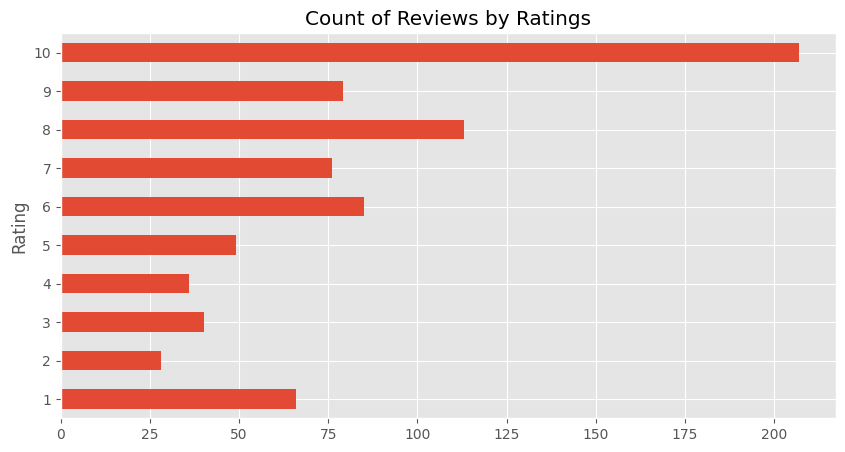

In [27]:
ax = df['Rating'].value_counts().sort_index()[1:].plot(kind='barh',
          title='Count of Reviews by Ratings',
          figsize=(10, 5))
# ax.set_xlabel('Review Stars')
plt.show()

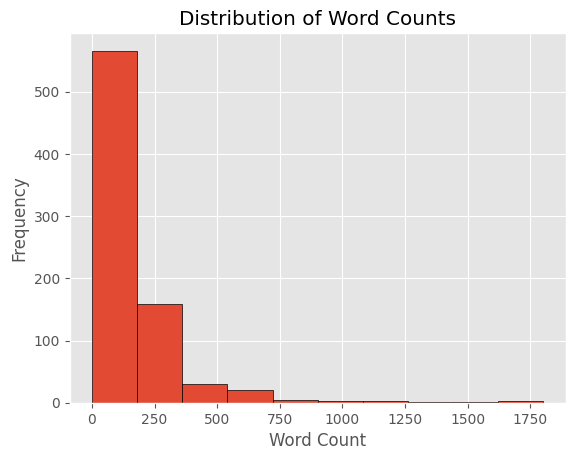

In [44]:
plt.hist(df['Count'], bins=10, edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts')
plt.show()

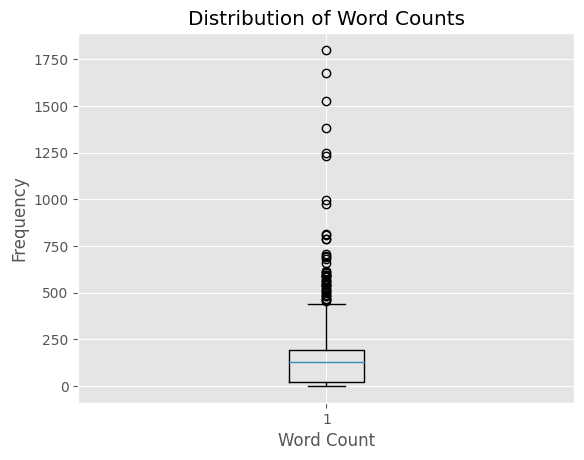

In [48]:
plt.boxplot(df['Count'])
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts')
plt.show()

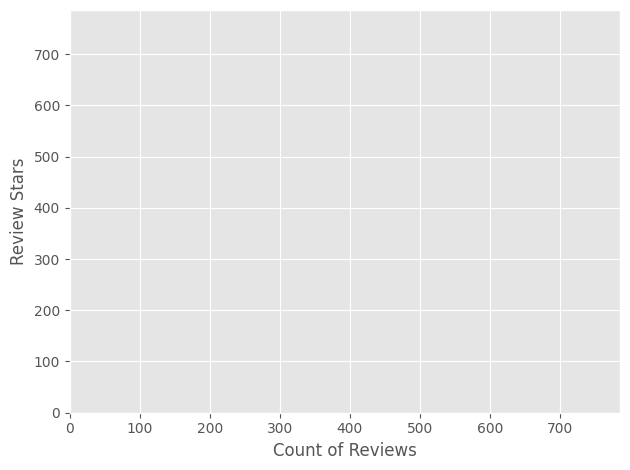

In [72]:
from matplotlib.animation import FuncAnimation

# Sort the DataFrame based on 'Date' column
df = df.sort_values(by='Date')

# Create the initial plot
fig, ax = plt.subplots()
bars = ax.barh([], [], height=0.5, align='center')
accumulated_data = []

def init():
    ax.set_xlim(0, len(df))
    ax.set_ylim(0, len(df))
    return bars

def update(frame):
    xdata = df['Date'][:frame + 1]
    ydata = df['Rating'][:frame + 1]
    accumulated_data.extend(ydata)  # Accumulate rating values
    ratings_count = pd.Series(accumulated_data).value_counts().sort_index()
    bars_data = ratings_count.reindex(range(1, 6), fill_value=0)
    for bar, height in zip(bars, bars_data):
        bar.set_width(height)
    ax.set_yticks(range(1, 6))
    ax.set_yticklabels(range(1, 6))
    ax.set_title('Accumulated Rating Distribution as of ' + str(xdata.iloc[-1].date()))
    return bars

# Animate the plot with FuncAnimation and store the animation in a variable
ani = FuncAnimation(fig, update, frames=len(df), init_func=init, blit=True, repeat=False)

# Save the animation (optional) or display it using plt.show()
# ani.save('accumulated_rating_distribution_animation.gif', writer='pillow', fps=2)
plt.xlabel('Count of Reviews')
plt.ylabel('Review Stars')
plt.tight_layout()

# Display the animation using plt.show()
plt.show()

In [58]:
from transformers import pipeline, AutoTokenizer

sent_pipeline = pipeline("sentiment-analysis", model='distilbert-base-uncased-finetuned-sst-2-english')

In [62]:
chunk_size = tokenizer.model_max_length
overlap = chunk_size / 2

In [59]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

In [64]:
for idx, row in df.iterrows():
    print(row['Count'])
    if row['Count'] > tokenizer.model_max_length:
        results = []
        for i in range(0, tokenized_text.input_ids.size(1), chunk_size - overlap):
            start = i
            end = min(i + chunk_size, tokenized_text.input_ids.size(1))
            inputs = {
                "input_ids": tokenized.input_ids[:, start:end],
                "attention_mask": tokenized.attention_mask[:, start:end],
            }
    
        output = model(**inputs)
        results.append(output)
        break
    else:
        result = sent_pipeline(row['Review'])[0]
        df.at[idx, 'Label'] = result['label']

219
149
115
3
289
464


RuntimeError: The size of tensor a (561) must match the size of tensor b (512) at non-singleton dimension 1

In [70]:
df.head()

,Title,Content,Rating,Date,Action,Review,Count,Label,Confidence
365,"Fun, unforgetable movie",This is the best movie I've seen in last 5 yea...,10,2023-07-19,28 out of 96 found this helpful. Was this revi...,"Fun, unforgetable movie This is the best movie...",74,NaN,NaN
165,Surprisingly Amazing For Everyone!,"Barbie was honestly a pleasant surprise, I wen...",10,2023-07-19,72 out of 229 found this helpful. Was this rev...,Surprisingly Amazing For Everyone! Barbie was ...,123,NaN,NaN
74,Drop the kids at Oppenheimer the adults can se...,"I'm not someone who often watches comedies, so...",8,2023-07-19,81 out of 318 found this helpful. Was this rev...,Drop the kids at Oppenheimer the adults can se...,170,NaN,NaN
655,Profundity Sold Seperately,It's a Barbie movie. It is as saccharine as Tr...,1,2023-07-19,244 out of 565 found this helpful. Was this re...,Profundity Sold Seperately It's a Barbie movie...,245,NaN,NaN
634,Promise of fun brought down by a bitter feeling,,1,2023-07-19,"675 out of 1,248 found this helpful. Was this ...",Promise of fun brought down by a bitter feeling,9,NaN,NaN


In [50]:
result

{'label': 'POSITIVE', 'score': 0.9176771640777588}

In [53]:
df.Count

0      219
1      149
2      115
3        3
4      289
      ... 
781      4
782      3
783    126
784    201
785    173
Name: Count, Length: 786, dtype: int64

In [61]:
tokenizer.model_max_length

512